In [1]:
import os
import time

import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import math
import pickle 
import sklearn
import graphviz
import xgboost as xgb
import lightgbm as lgbm
from pickle import dump

import contextily as cx
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance as plot_importance_XGB
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as plot_importance_LGBM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Dropout
from os import listdir
from os.path import isfile, join
from platform import python_version

import re

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]



print(pd.__version__) # should be 1.3.0
print(sklearn.__version__) # should be 0.24.1
print(tf.__version__) # should be 2.4.0
print(python_version()) #should be 3.8.2

1.3.0
0.24.1
2.4.0
3.8.2


In [9]:
def Initial_MLP_train_predict(Region_optfeatures, RegionTrain, Region, epochs, MLP_Models):
    
    #get y data
    y = RegionTrain[Region]['SWE']
    
    #get max SWE for normalization and prediction
    SWEmax = max(RegionTrain[Region]['SWE'])
    y = y/SWEmax

    #get optimal features for each regions (from LGBM RFE)
    optfeatures = list(Region_optfeatures[Region])
    
    #make a df copy of specific region
    df = RegionTrain.get(Region).copy()
    df = df[optfeatures]
    
    ### replace special character ':' with '__' 
    df = df.rename(columns = lambda x:re.sub(':', '__', x))

    #change all na values to prevent scaling issues
    df[df< -9000]= -10

    #normalize training data    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)


    
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    #set up prediction dataframe
    pred_obs = pd.DataFrame(y_test)
    pred_obs = pred_obs.rename(columns = {'SWE':'y_test'})
    
    
    #set up model checkpoint to be able to extract best models
    checkpointfilename ='SWE_{val_loss:.8f}.h5'
    checkpoint_filepath = 'Model/Model_Calibration/'+MLP_Models+'/' +Region+ '/'
    
    #save scaler data here too
    dump(scaler, open(checkpoint_filepath+'scaler.pkl', 'wb'))
    
    checkpoint_filename = checkpoint_filepath+checkpointfilename
    callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
     #need to save SWEmax
    SWEmax = np.array(SWEmax)
    np.save(checkpoint_filepath+'SWEmax.npy' , SWEmax)

    #get the training data shape to form MLP model input layer
    shape = X_train.shape

    #set up layer-nodes for MLP model
    LD1=128
    #seems like only slight increase in runtime with another layer
    LD2=128
    #seems like only slight increase in runtime with another layer
    LD3=64
    #seems like only slight increase in runtime with another layer, sig per improvement 
    LD4=64
    LD5=32
    LD6=16
    LD7=5

    input_1 = layers.Input(shape=(shape[1],))
    x = layers.Dense(LD1, activation="relu")(input_1)
    x = layers.Dense(LD2, activation="relu")(x)
    x = layers.Dense(LD3, activation="relu")(x)
    x = layers.Dense(LD4, activation="relu")(x)
    x = layers.Dense(LD5, activation="relu")(x)
    x = layers.Dense(LD6, activation="relu")(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=input_1,outputs=x)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4), metrics=['mse'])
    print(model.summary())
    #training time for 50 epochs took 3601seconds, 60 mins, 500 epochs
    model.fit(X_train, y_train, epochs=epochs, batch_size=100,
                        validation_data=(X_test,y_test),shuffle=True,callbacks=[callback], verbose=0)
    
    
    
     #load the model with highest performance
    bestmodel = [f for f in listdir(checkpoint_filepath) if isfile(join(checkpoint_filepath, f))]
    bestmodel.sort(key=natural_keys)
    bestmodel = checkpoint_filepath+bestmodel[0]
    model=load_model(bestmodel)
    print(bestmodel)
    
    
    #make predictions and rescale, the 10 is bc changed -9999 values to -10
    y_pred = (SWEmax* model.predict(X_test))

    y_pred[y_pred < 0 ] = 0
    y_test = (SWEmax * y_test)
    pred_obs['y_test'] = y_test
    pred_obs['y_pred'] = y_pred 
    pred_obs['Region'] = region
    
    #Run model evaluate function
    print(model.evaluate(X_train, y_train))
    r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    print(' R2 is ', r2_test)
    print(' RMSE is ', rmse_test)
    print("MSE: %.4f" % mean_squared_error(y_test, y_pred))
    
    error_data = np.array([region, round(r2_test,2),  round(rmse_test,2)])
    error = pd.DataFrame(data = error_data.reshape(-1, len(error_data)), columns = ['Region', 'R2', 'RMSE'])
    print(error)


    #plot graph
    plt.scatter( pred_obs['y_test'],pred_obs['y_pred'], s=5, color="blue", label="Predictions")
    plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
    plt.xlabel('Observed SWE')
    plt.ylabel('Predicted SWE')

    #plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
    plt.title(region)
    plt.legend()
    plt.show()
    
    return pred_obs, error

In [3]:
os.getcwd()
os.chdir('..')
os.getcwd()
os.chdir('..')
os.getcwd()

'/uufs/chpc.utah.edu/common/home/civil-group1/ItalianAlps/SnowCast/Final_Model'

In [4]:
'''
Next to last model to check, run the new training data set splitting S_Sierra Elevation,
removing mid season 0 values, and removing -9999 prev_swe values

'''

'\nNext to last model to check, run the new training data set splitting S_Sierra Elevation,\nremoving mid season 0 values, and removing -9999 prev_swe values\n\n'

In [7]:
### define new regions
Region_list = ['N_Sierras',
               'S_Sierras_High',
               'S_Sierras_Low',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]


#make model file directories
for region in Region_list:
    os.makedirs('Model/Model_Calibration/Initial_MLP/'+region)

    
#load RFE optimized features
Region_optfeatures= pickle.load(open("Model/Initial_Models_Final/opt_features_initial.pkl", "rb"))

### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Data/Model_Calibration_Data/RegionTrain_Final.h5', region)
    
#Reorder regions
RegionTrain = {k: RegionTrain[k] for k in Region_list}

Training model for  N_Sierras
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               6016      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (N

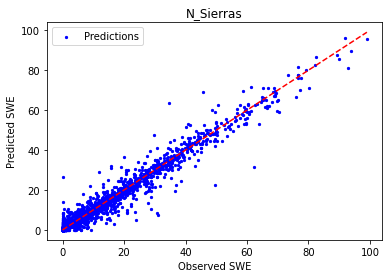

Training model for  S_Sierras_High
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               3712      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)        

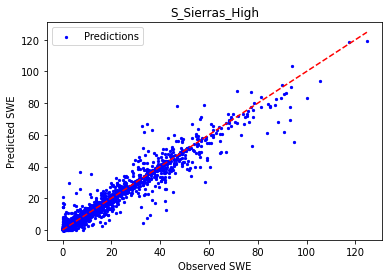

Training model for  S_Sierras_Low
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 142)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               18304     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)         

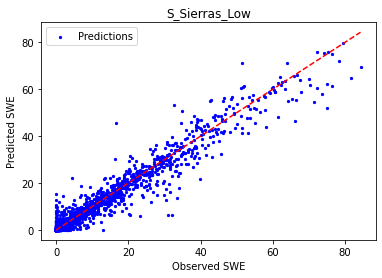

Training model for  Greater_Yellowstone
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               2560      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)   

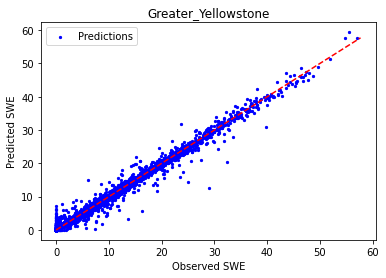

Training model for  N_Co_Rockies
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               2816      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)          

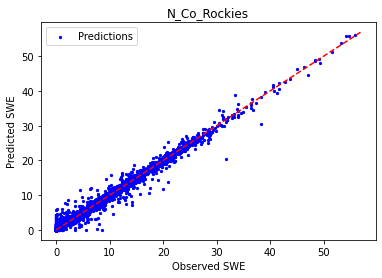

Training model for  SW_Mont
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (N

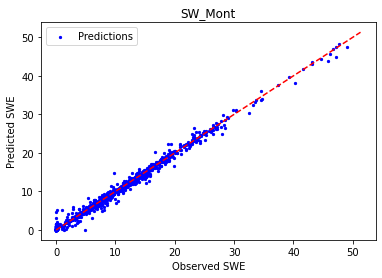

Training model for  SW_Co_Rockies
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               2944      
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)         

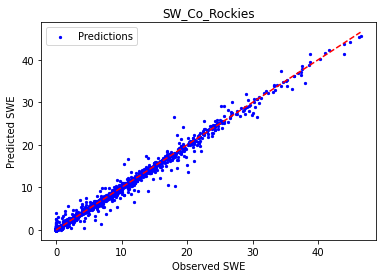

Training model for  GBasin
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 61)]              0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               7936      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_54 (Dense)             (No

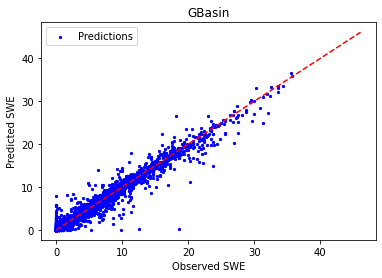

Training model for  N_Wasatch
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               2816      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_61 (Dense)             

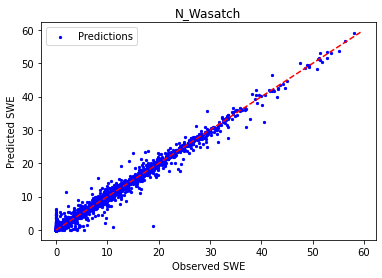

Training model for  N_Cascade
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               4096      
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             

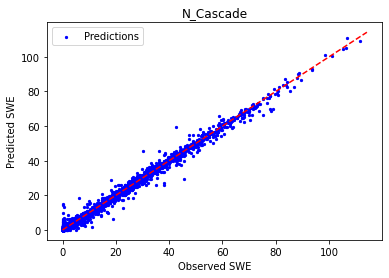

Training model for  S_Wasatch
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 25)]              0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               3328      
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_72 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_73 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_75 (Dense)            

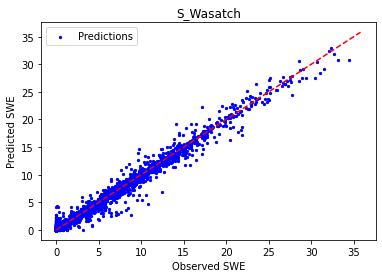

Training model for  SW_Mtns
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               2048      
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_81 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_82 (Dense)             (

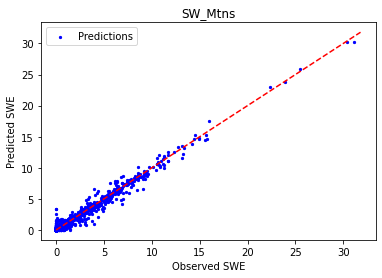

Training model for  E_WA_N_Id_W_Mont
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_86 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_87 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_88 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_89 (Dense)     

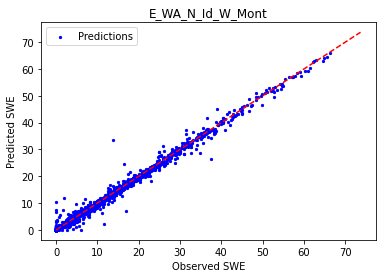

Training model for  S_Wyoming
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 37)]              0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               4864      
_________________________________________________________________
dense_92 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_93 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_95 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_96 (Dense)            

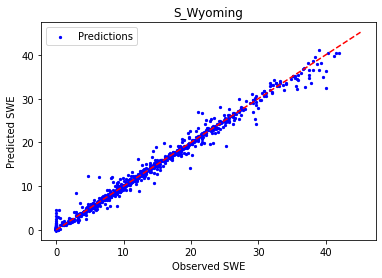

Training model for  SE_Co_Rockies
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 26)]              0         
_________________________________________________________________
dense_98 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_99 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_100 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_101 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_102 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_103 (Dense)       

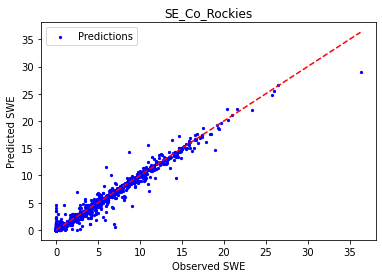

Training model for  Sawtooth
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 37)]              0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)               4864      
_________________________________________________________________
dense_106 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_107 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_108 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_109 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_110 (Dense)            

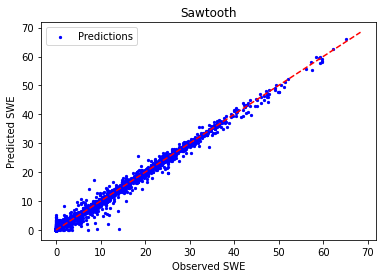

Training model for  Ca_Coast
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 11)]              0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_113 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_114 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_115 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_116 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_117 (Dense)            

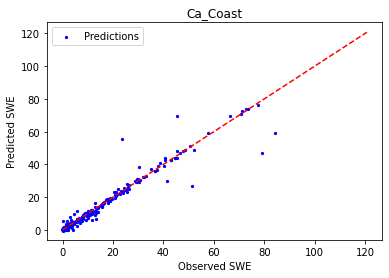

Training model for  E_Or
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
dense_119 (Dense)            (None, 128)               2048      
_________________________________________________________________
dense_120 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_121 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_122 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_123 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_124 (Dense)            (Non

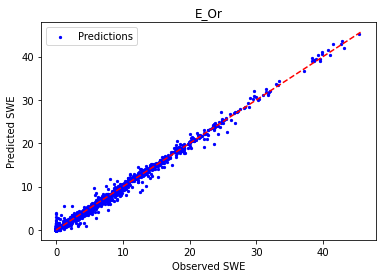

Training model for  N_Yellowstone
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 19)]              0         
_________________________________________________________________
dense_126 (Dense)            (None, 128)               2560      
_________________________________________________________________
dense_127 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_128 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_129 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_130 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_131 (Dense)       

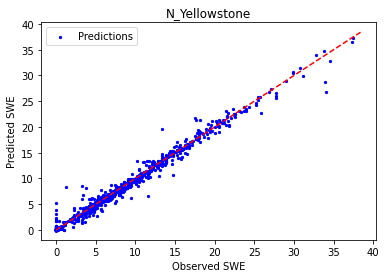

Training model for  S_Cascade
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 23)]              0         
_________________________________________________________________
dense_133 (Dense)            (None, 128)               3072      
_________________________________________________________________
dense_134 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_135 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_136 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_137 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_138 (Dense)           

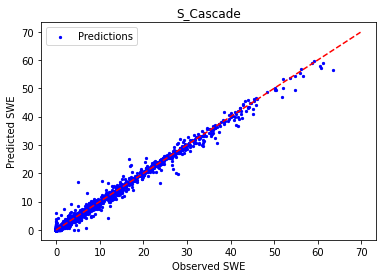

Training model for  Wa_Coast
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 14)]              0         
_________________________________________________________________
dense_140 (Dense)            (None, 128)               1920      
_________________________________________________________________
dense_141 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_142 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_143 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_144 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_145 (Dense)            

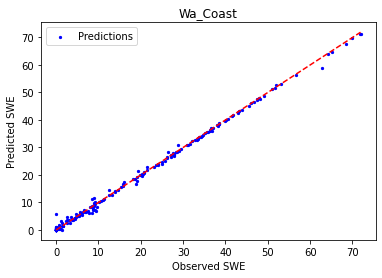

Training model for  Greater_Glacier
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
dense_147 (Dense)            (None, 128)               5376      
_________________________________________________________________
dense_148 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_149 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_150 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_151 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_152 (Dense)     

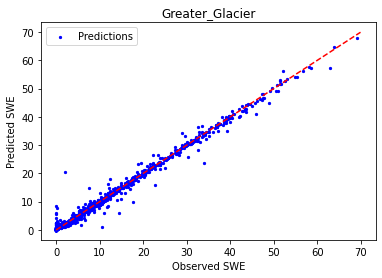

Training model for  Or_Coast
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_154 (Dense)            (None, 128)               2688      
_________________________________________________________________
dense_155 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_156 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_157 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_158 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_159 (Dense)            

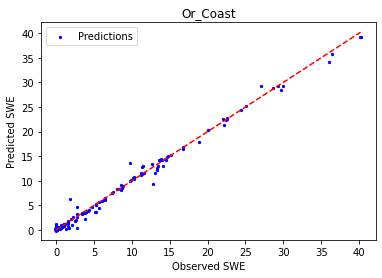

In [10]:
Model_Results_Final = pd.DataFrame(columns = ['y_test', 'y_pred',  'Region'])
Model_Error_Final = pd.DataFrame(columns = ['Region', 'R2', 'RMSE'])


for region in Region_list:
    print('Training model for ', region)

    
    #Training model and getting results
    pred_obs, error = Initial_MLP_train_predict(Region_optfeatures, RegionTrain, region, 3000, 'Initial_MLP')
    Model_Results_Final = Model_Results_Final.append(pred_obs)
    Model_Error_Final = Model_Error_Final.append(error)

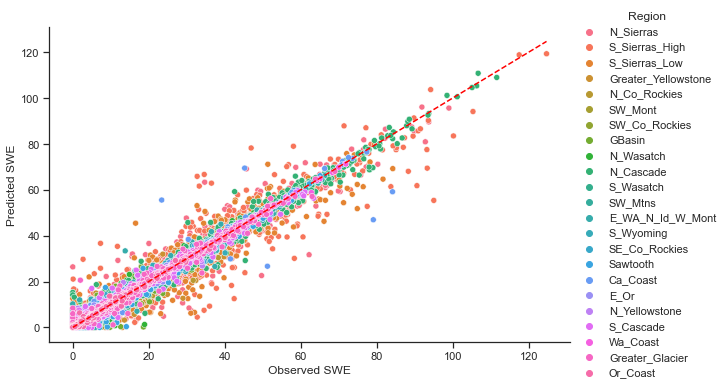

In [11]:
import seaborn as sns

#Plot all region predictions together

sns.set(style='ticks')
#_regions= ['E_Or', 'Ca_Coast']
SWEmax = max(Model_Results_Final['y_test'])

sns.relplot(data=Model_Results_Final, x='y_test', y='y_pred', hue='Region', hue_order=Region_list, aspect=1.61)
plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()

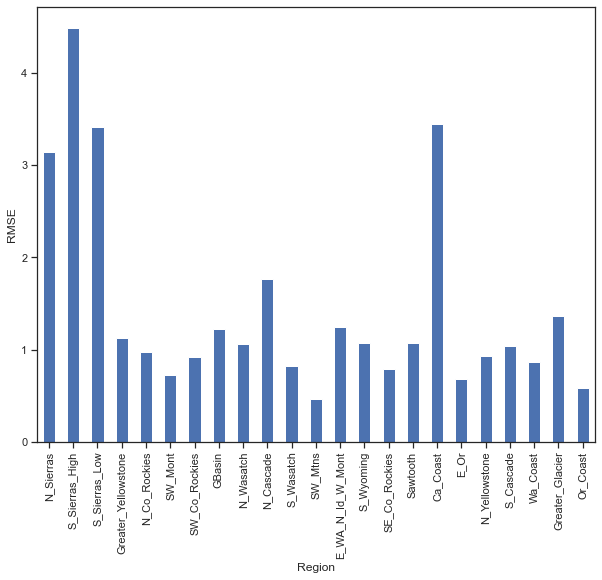

In [12]:
#plot each regions RMSE
Model_Error_Final['RMSE'] = Model_Error_Final['RMSE'].astype(float)


ax = Model_Error_Final.plot.bar(x="Region", y="RMSE", rot = 90, figsize = (10, 8))
plt.ylabel('RMSE')
ax.get_legend().remove()

In [13]:
Model_Error_Final

,Region,R2,RMSE
0,N_Sierras,0.96,3.14
0,S_Sierras_High,0.94,4.49
0,S_Sierras_Low,0.94,3.41
0,Greater_Yellowstone,0.99,1.13
0,N_Co_Rockies,0.98,0.98
0,SW_Mont,0.99,0.73
0,SW_Co_Rockies,0.99,0.92
0,GBasin,0.96,1.22
0,N_Wasatch,0.99,1.06
0,N_Cascade,0.99,1.77


In [14]:
#weighted RMSE

T_Initial_RMSE = sklearn.metrics.mean_squared_error(Model_Results_Final['y_test'], Model_Results_Final['y_pred'], squared = False)
print('Using Delta_SWE feature the weighted RMSE is ', T_Initial_RMSE)

Using Delta_SWE feature the weighted RMSE is  1.787568454837518
